# Visualization tools

In [1]:
import matplotlib.pyplot as plt

def print_separate(image, result, score_thresh=0.5):
    plt.figure()
    plt.imshow(image.transpose((1,2,0)))
    for obj_i in range(len(result['nocs'])):
        if result["scores"][obj_i] < score_thresh: continue
        masked = result['masks'][obj_i] * result['nocs'][obj_i]
        plt.figure()
        plt.title(f'score {result["scores"][obj_i]}')
        plt.imshow(masked.clone().detach().cpu().numpy().transpose(1,2,0))

def print_all(image, result, score_thresh=0.5):
    plt.figure()
    plt.imshow(image.transpose((1,2,0)))
    idxs = result['scores'] > score_thresh
    accumulated = (result['masks'][idxs] * result['nocs'][idxs]).sum(0)
    plt.figure()
    plt.imshow(accumulated.clone().detach().cpu().numpy().transpose(1,2,0))

# Setup model

In [11]:
%load_ext autoreload
%autoreload 2

root = '/home/baldeeb/Code/pytorch-NOCS'

import sys; sys.path.insert(0, root)

# Initialize detector
from inference_wrapper import NocsDetector
K = [[591.0125, 0,          322.525], 
    [0,         590.16775,  244.11084], 
    [0,         0,          1]]
# chkpt = f'{root}/checkpoints/nocs_classification/2023-05-25_13-46-18/one_class_frozen_backbone_4.pth'
# chkpt = f'{root}/checkpoints/nocs_classification/2023-06-04_21-47-00/multiview_consistency_experiment_4.pth'
# chkpt = f'{root}/checkpoints/nocs_classification/2023-06-13_21-33-41/pixelwiseMultiview_fromPretrained_4.pth'
chkpt = f'{root}/checkpoints/nocs_classification/2023-06-16_15-05-50/alignDepthAndNocs_allHeads_fromScratchOnOldData_4.pth'


det = NocsDetector(chkpt, K, 
                   return_annotated_image=True, 
                   perform_alignment=True, 
                   num_classes=2, 
                   override_num_classes=True,
                   device='cuda:1')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load & Use random images

In [19]:

# Get some data
import cv2
import numpy as np

IMG_PATH = '/media/baldeeb/ssd2/Data/SpotStills/9_hand_color_image.jpg'
DEPTH_PATH = '/media/baldeeb/ssd2/Data/SpotStills/9_hand_depth_in_hand_color_frame.jpg'

# IMG_PATH = '/home/baldeeb/Downloads/IMG_7329.jpg'
# IMG_PATH = '/home/baldeeb/Code/bd_spot_wrapper/data/output/front_left/color/70_frontleft_fisheye_image.png'
# # IMG_PATH = '/media/baldeeb/ssd2/Data/SpotStills/11_hand_color_image.jpg'

images = cv2.imread(IMG_PATH)
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
images = images.transpose(2,0,1)[None] / 255.0
images = images.astype(np.float32)
depth = cv2.imread(DEPTH_PATH, cv2.IMREAD_ANYDEPTH)
depth = depth[None].astype(np.float32) / 100.0

results = det(images, depth)
print(f'found {len(results[0]["nocs"])} objects')

# images.shape, images.dtype, images.min(), images.max(), depth.shape, depth.dtype, depth.min(), depth.max()

found 5 objects


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


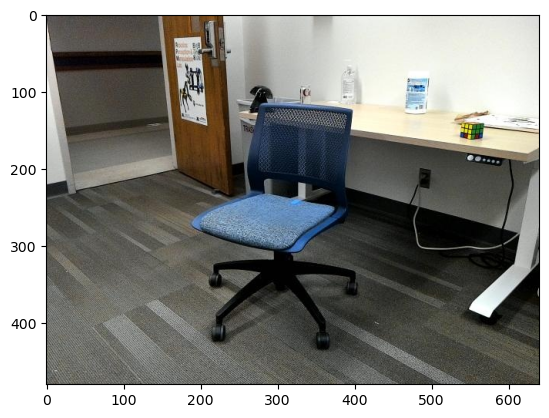

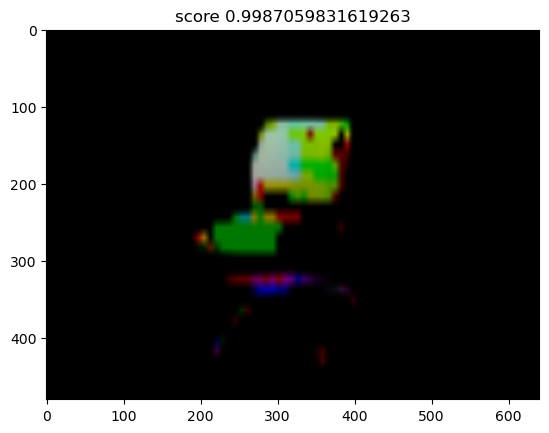

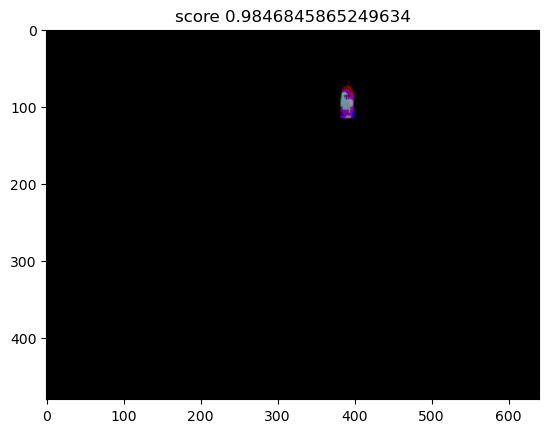

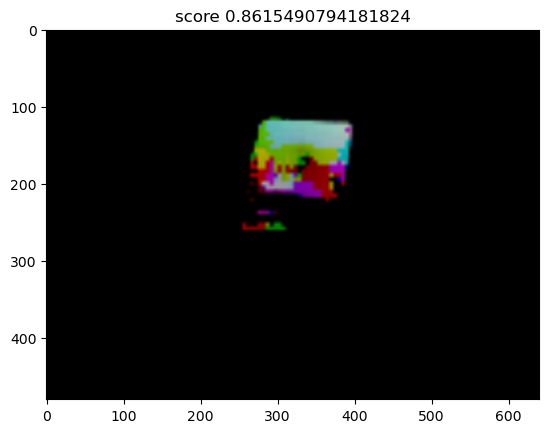

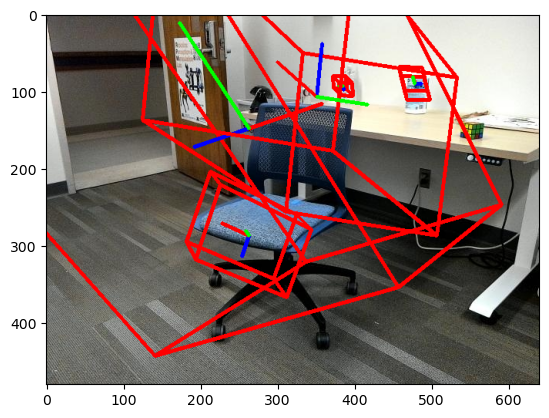

In [23]:
print_separate(images[0], results[0])
# print_all(images[0], results[0])
plt.figure()
plt.imshow(results[0]['annotated_image'])
plt.show()

In [5]:
%load_ext autoreload
%autoreload 2
import torch
from models.nocs import get_nocs_resnet50_fpn
from utils.load_save import load_nocs
chkpt = '/home/baldeeb/Code/pytorch-NOCS/checkpoints/nocs_classification/2023-05-24_15-49-43/frozen_backbone_4.pth'
nocs = load_nocs(chkpt)

nocs.eval()
nocs.cuda()

i = torch.from_numpy(images).to('cuda')
n = nocs(i)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using recorded ros bags

In [12]:
from datasets.rosbag_dataset import RosbagReader, collate_fn, get_topics_in_path
import torch
bag_path = '/media/baldeeb/ssd2/Data/kinect/long_bag_of_chairs.bag'

print(get_topics_in_path(bag_path))

topic_names = {'/rtabmap/rtabmap/localization_pose': 'camera_pose',
               '/k4a/depth_to_rgb/camera_info': 'intrinsics',
               '/k4a/depth_to_rgb/image_raw': 'depth',
               '/k4a/rgb/image_raw': 'color',}
print(f'topics requested: {list(topic_names.keys())}')

dataset = RosbagReader(bag_path, topic_names)
images, data = collate_fn([dataset[i] for i in range(8)])
depth = torch.stack([d['depth'] for d in data])
# images.shape, images.dtype, images.min(), images.max(), depth.shape, depth.dtype, depth.min(), depth.max()
data[0].keys()

# Update intrinsics of the detector
det._K = data[0]['intrinsics'].cpu().numpy()



['/k4a/depth_to_rgb/camera_info', '/k4a/depth_to_rgb/image_raw', '/k4a/rgb/image_raw', '/rtabmap/rtabmap/localization_pose']
topics requested: ['/rtabmap/rtabmap/localization_pose', '/k4a/depth_to_rgb/camera_info', '/k4a/depth_to_rgb/image_raw', '/k4a/rgb/image_raw']


/home/baldeeb/Code/pytorch-NOCS/utils/evaluation/tools.py:59: RuntimeWarning: invalid value encountered in divide
  new_coordinates = new_coordinates[:3, :]/new_coordinates[3, :]
/home/baldeeb/Code/pytorch-NOCS/utils/alinging_tools.py:183: RuntimeWarning: divide by zero encountered in double_scalars
  ScaleFact = 1/varP * np.sum(D) # scale factor
/home/baldeeb/Code/pytorch-NOCS/utils/alinging_tools.py:183: RuntimeWarning: invalid value encountered in double_scalars
  ScaleFact = 1/varP * np.sum(D) # scale factor
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


passed images: torch.Size([8, 3, 1536, 2048]), depth: torch.Size([8, 1536, 2048])
got results: ['boxes', 'labels', 'scores', 'masks', 'nocs', 'transforms', 'scales', 'annotated_image']
found 6 objects in image 0
found 8 objects in image 4


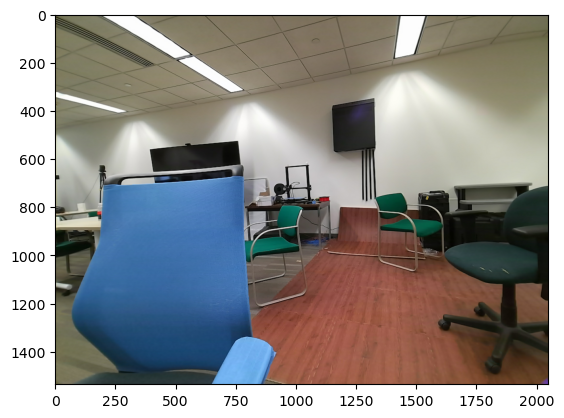

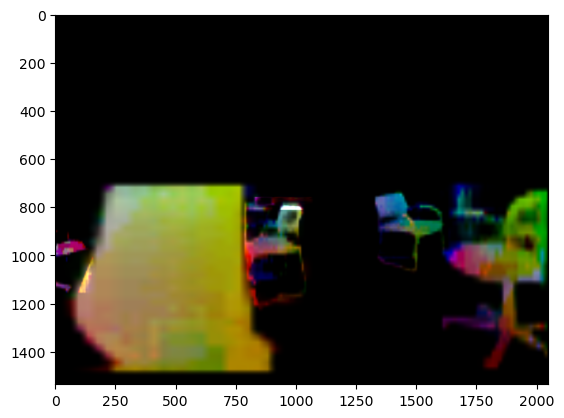

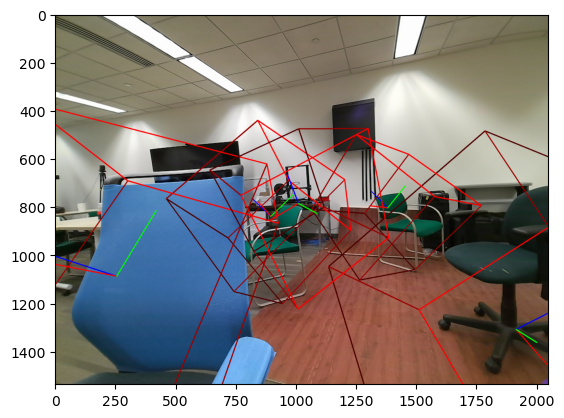

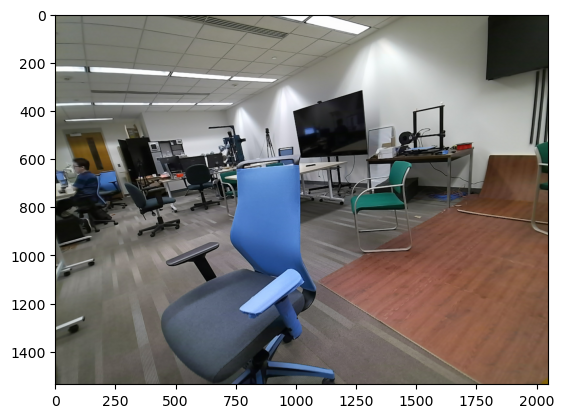

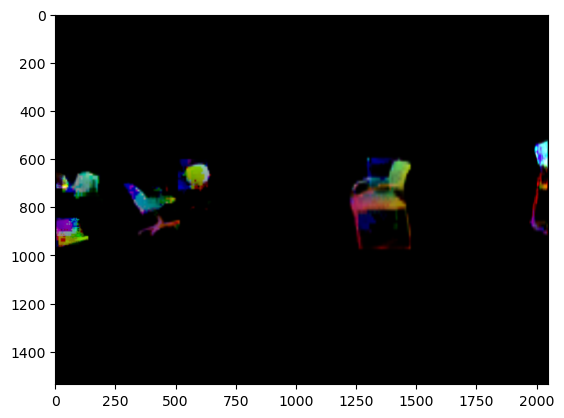

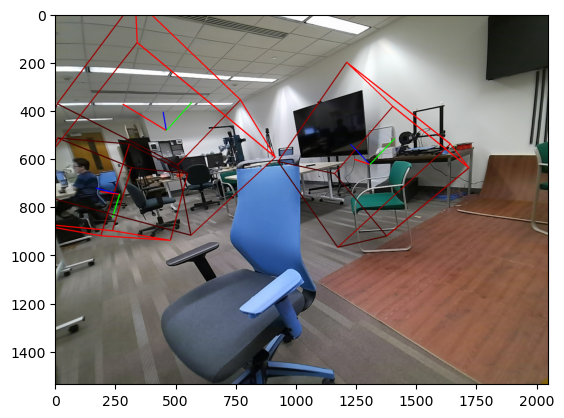

In [21]:
results = det(images, depth)

print(f'passed images: {images.shape}, depth: {depth.shape}')
print(f'got results: {list(results[0].keys())}')

for i in [0, 4]:
    img, r = images[i].numpy(), results[i]
    print(f'found {len(r["nocs"])} objects in image {i}')
    print_all(img, r, score_thresh=0.5)
    # print_separate(img, r)
    plt.figure(); plt.imshow(r['annotated_image'])
    
# plt.figure()
# plt.imshow(depth[0].cpu().numpy())

In [20]:
import imageio
import numpy as np

ims = [r['nocs'].clone().detach().sum(0).permute(1,2,0).float().cpu().numpy() * 255.0 for r in results]
# ims = [r['annotated_image'] for r in results]
ims = np.stack(ims).astype(np.uint8)
imageio.mimsave('../data/temp/movie.gif', ims, duration=1000, loop=1)
